In [1]:

# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from scipy import misc
import threading

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import newax25 as ax25

import multiprocessing

from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign




%matplotlib inline

In [2]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)//gcd(x,y), numbers, 1)


In [3]:
sd.query_devices()

  0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 USB Audio Device: - (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)

In [4]:
builtin_idx = 0
usb_idx = 2
sd.default.samplerate=48000
sd.default.channels = 1

In [5]:
GPIO.setmode(GPIO.BOARD)
PTT = 12
GPIO.setup(PTT, GPIO.OUT, initial = 0)
GPIO.output(PTT, GPIO.LOW)


In [6]:
import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

array_1d_int = npct.ndpointer(dtype=np.int, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]



class TNCaprs:
    
    def __init__(self, fs = 48000.0, Abuffer = 512, Nchunks=10):
        
        #  Implementation of an afsk1200 TNC. 
        #
        #  The TNC processes a `Abuffer` long buffers, till `Nchunks` number of buffers are collected into a large one.
        #  This is because python is able to more efficiently process larger buffers than smaller ones.
        #  Then, the resulting large buffer is demodulated, sampled and packets extracted.
        #
        # Inputs:
        #    fs  - sampling rate
        #   TBW  -  TBW of the demodulator filters
        #   Abuffer - Input audio buffers from Pyaudio
        #   Nchunks - Number of audio buffers to collect before processing
        #   plla    - agressivness parameter of the PLL
        
        
        ## compute sizes based on inputs
        self.TBW = 2.0   # TBW for the demod filters
        self.N = (int(fs/1200*self.TBW)//2)*2+1   # length of the mark-space filters for demod
        self.fs = fs     # sampling rate   
        self.BW = 1200      # BW of filter based on TBW
        self.Abuffer = Abuffer             # size of audio buffer
        self.Nchunks = Nchunks             # number of audio buffers to collect
        self.Nbuffer = Abuffer*Nchunks+(self.N*3-3)         # length of the large buffer for processing
        self.Ns = 1.0*fs/1200.0 # samples per symbol
        
        ## state variables for the modulator
        self.prev_ph = 0  # previous phase to maintain continuous phase when recalling the function
        
        ##  Generate Filters for the demodulator
        self.h_lp = signal.firwin(self.N,self.BW/fs*1.0,window='hanning')
        self.h_lpp = signal.firwin(self.N,self.BW*2*1.2/fs,window='hanning')
        self.h_space = self.h_lp*exp(1j*2*pi*(2200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_mark = self.h_lp*exp(1j*2*pi*(1200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_bp = signal.firwin(self.N,self.BW/fs*2.2,window='hanning')*exp(1j*2*pi*1700*(r_[0:self.N]-self.N//2)/fs)


        ## PLL state variables  -- so conntinuity between buffers is preserved
        self.dpll = np.round(2.0**32 / self.Ns).astype(np.int32)    # PLL step
        self.pll =  0                # PLL counter
        self.ppll = -self.dpll       # PLL counter previous value -- to detect overflow
        self.plla = 0.74             # PLL agressivness (small more agressive)
        

        ## state variable to NRZI2NRZ
        self.NRZIprevBit = bool(1)  
        
        ## State variables for findPackets
        self.state='search'   # state variable:  'search' or 'pkt'
        self.pktcounter = 0   # counts the length of a packet
        self.packet = bitarray.bitarray([0,1,1,1,1,1,1,0])   # current packet being collected
        self.bitpointer = 0   # poiter to advance the search beyond what was already searched in the previous buffer

        ## State variables for processBuffer
        self.buff = zeros(self.Nbuffer)   # large overlapp-save buffer
        self.chunk_count = 0              # chunk counter
        self.oldbits = bitarray.bitarray([0,0,0,0,0,0,0])    # bits from end of prev buffer to be copied to beginning of new
        self.Npackets = 0                 # packet counter
        
        
    
    
    def NRZ2NRZI(self,NRZ, prevBit = True):
        NRZI = NRZ.copy() 
        for n in range(0,len(NRZ)):
            if NRZ[n] :
                NRZI[n] = prevBit
            else:
                NRZI[n] = not(prevBit)
            prevBit = NRZI[n]
        return NRZI
    



    def NRZI2NRZ(self, NRZI):  
        NRZ = NRZI.copy() 
    
        for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == self.NRZIprevBit
            self.NRZIprevBit = NRZI[n]
    
        return NRZ
    
    def KISS2bits(self,KISS):
        # function that takes a KISS frame sent via TCP/IP and converts it to an APRSpacket bit stream.
        
        bits = bitarray.bitarray(endian="little")
        bits.frombytes(KISS)
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
            
        bits.frombytes(fcs.digest())
        return bitarray.bitarray('01111110') + ax25.bit_stuff(bits) + bitarray.bitarray('01111110') 
     
    def bits2KISS(self,bits):
        # function that takes a bitstream of an APRS-packet, removes flags and FCS and unstuffs the bits
        bitsu = ax25.bit_unstuff(bits[8:-8])
        return  bitsu[:-16].tobytes() 
    
    
    def modulate(self,bits):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
        fss = lcm((1200,self.fs))
        deci = fss//self.fs
    
        Nb = fss//1200
        nb = len(bits)
        NRZ = ones((nb,Nb))
        for n in range(0,nb):
            if bits[n]:
                NRZ[n,:]=-NRZ[n,:]
    
        freq = 1700 + 500*NRZ.ravel()
        ph = self.prev_ph + 2.0*pi*integrate.cumtrapz(freq)/fss
        sig = cos(ph[::deci])
        
        return sig 
    
    def modulatPacket(self, callsign, digi, dest, info, preflags=80, postflags=80 ):
        
        # given callsign, digipath, dest, info, number of pre-flags and post-flags the function contructs
        # an appropriate aprs packet, then converts them to NRZI and calls `modulate` to afsk 1200 modulate the packet. 
        
        packet = ax25.UI(destination=dest,source=callsign, info=info, digipeaters=digi.split(b','),)
        prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(preflags,)).tolist())
        suffix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(postflags,)).tolist())
        sig = self.modulate(self.NRZ2NRZI(prefix + packet.unparse()+suffix))

        return sig
    
    

    def demod(self, buff):
        #Demodulates a buffer and returns valid NRZ
    
        SIG = np.convolve(buff,self.h_bp,mode='valid')
        NRZ = abs(np.convolve(SIG,self.h_mark,mode='valid')) - abs(np.convolve(SIG,self.h_space,mode='valid'))
        NRZ = np.convolve(NRZ,self.h_lpp,mode='valid')
        return NRZ


    def FastPLL(self,NRZa):
        recbits = np.zeros(len(NRZa)//(self.fs//1200)*2,dtype=np.int32)
        pll = np.zeros(1,dtype = np.int32)
        pll[0] = self.pll
        ppll = np.zeros(1,dtype = np.int32)
        ppll[0] = self.ppll
        
        #print("pll = ",pll,"   ppll=",ppll)
        
        
        NRZb = (NRZa > 0).astype(np.int32)
        tot = libcd.pll(NRZb,len(NRZb),recbits,recbits,pll,ppll,self.dpll,self.plla)
        
        self.ppll = ppll.copy()
        self.pll = pll.copy()
        
        #print("post: pll = ",pll,"   ppll=",ppll)
        
        return bitarray.bitarray(recbits[:tot].tolist())
    
    def PLL(self, NRZa):
       #print("running PLL")
        idx = zeros(len(NRZa)//int(self.Ns)*2)   # allocate space to save indexes        
        c = 0
        
        for n in range(1,len(NRZa)):
            if (self.pll < 0) and (self.ppll >0):
                idx[c] = n
                c = c+1
        
            if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
                self.pll = np.int32(self.pll*self.plla)
            
        
            self.ppll = self.pll
            self.pll = np.int32(self.pll+ self.dpll)
    
        return idx[:c].astype(np.int32) 
    
   

    def findPackets(self,bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = self.bitpointer
        
        # Loop over bits
        while (n < len(bits)-7) :
            # default state is searching for packets
            if self.state is 'search':
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    self.state = 'pkt'
                    self.packet=flg.copy()
                    self.pktcounter = 8
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif self.state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if self.pktcounter > 200:
                        #print('packet found!')
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        self.state = 'search'
                        self.packet.extend(flg)
                        packets.append(self.packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        self.state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if self.pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer        
                        self.packet.append(bits[n])
                        self.pktcounter = self.pktcounter + 1
                        n = n + 1
                    else:  #runaway packet
                        #runaway packet, switch state to searching, and advance pointer
                        self.state = 'search'
                        n = n + 1
        
        self.bitpointer = n-(len(bits)-7) 
        return packets

    
    # function to generate a checksum for validating packets
    def genfcs(self,bits):
        # Generates a checksum from packet bits
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
    
        digest = bitarray.bitarray(endian="little")
        digest.frombytes(fcs.digest())

        return digest




    # function to parse packet bits to information
    def decodeAX25(self,bits, deepsearch=False):
        ax = ax25.AX25()
        ax.info = "bad packet"
    
    
        bitsu = ax25.bit_unstuff(bits[8:-8])
    
        
        #foundPacket = False
        #if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()):
        #        foundPacket = True
        #elif deepsearch: 
        #    tbits = bits[8:-8]
        #    for n in range(0,len(tbits)):
        #        tbits[n] = not tbits[n]
        #        if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()):
        #            foundPacket = True
        #            print("Success deep search")
        #            break
        #        tbits[n] = not tbits[n]
        # 
        #if foundPacket == False:
        #    return ax
        
        if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
            #print("failed fcs")
            return ax
                  
    
        bytes = bitsu.tobytes()
        ax.destination = ax.callsign_decode(bitsu[:56]).decode('ascii')
        source = ax.callsign_decode(bitsu[56:112]).decode('ascii')
    
        if source[-1].isdigit() and source[-1]!="0":
            ax.source = "".join((source[:-1],'-',source[-1]))
        else:
            ax.source = source[:-1]
    
        digilen=0    
    
        if bytes[14]=='\x03' and bytes[15]=='\xf0':
            digilen = 0
        else:
            for n in range(14,len(bytes)-1):
                if bytes[n] & 1:
                    digilen = (n-14)+1
                    break

        #    if digilen > 56:
        #        return ax
        ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8]).decode('ascii')
        ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    
        return ax

    def processBuffer(self, buff_in):
        
        # function processes an audio buffer. It collect several small into a large one
        # Then it demodulates and finds packets.
        #
        # The function operates as overlapp and save
        # The function returns packets when they become available. Otherwise, returns empty list
        
        N = self.N
        NN = (N*3 -3 )
        
        
        Nchunks = self.Nchunks
        Abuffer = self.Abuffer
        fs = self.fs
        Ns = self.Ns
        
        validPackets=[]
        packets=[]
        NRZI=[]
        idx = []
        bits = []
        
        # Fill in buffer at the right place
        self.buff[NN+self.chunk_count*Abuffer:NN+(self.chunk_count+1)*Abuffer] = buff_in.copy()
        self.chunk_count = self.chunk_count + 1
        
        
        # number of chunk reached -- process large buffer
        if self.chunk_count == Nchunks:
            # Demodulate to get NRZI
            NRZI = self.demod(self.buff)
            # compute sampling points, using PLL
            #idx = self.PLL(NRZI)
            # Sample and make a decision based on threshold
            #bits = bitarray.bitarray((NRZI[idx]>0).tolist())
            
            bits = self.FastPLL(NRZI)
            # In case that buffer is too small raise an error -- must have at least 7 bits worth
            if len(bits) < 7:
                raise ValueError('number of bits too small for buffer')
            
            # concatenate end of previous buffer to current one
            bits = self.oldbits + self.NRZI2NRZ(bits)
            
            # store end of bit buffer to next buffer
            self.oldbits = bits[-7:].copy()
            
            # look for packets
            packets = self.findPackets(bits)
            
            # Copy end of sample buffer to the beginning of the next (overlapp and save)
            self.buff[:NN] = self.buff[-NN:].copy()
            
            # reset chunk counter
            self.chunk_count = 0
            
            # checksum test for all detected packets
            for n in range(0,len(packets)):
                if len(packets[n]) > 200: 
                    try:
                        ax = self.decodeAX25(packets[n])
                    except:
                        ax = ax25.AX25()
                        ax.info = "bad packet"
                    if ax.info != 'bad packet':
                        validPackets.append(packets[n])
                        
            
        return validPackets

In [113]:
callsign = "KM6QHD"
fname = b"calBlue.tiff"
# fname = b'rec.tar.bz2'
f = open(fname,"rb")

fs = 48000
modem = TNCaprs(fs = fs ,Abuffer = 512,Nchunks = 1)
    


Qout = Queue.Queue()



print("Putting packets in Queue")
npp = 0
tmp = modem.modulatPacket(callsign, b"", 'BEGIN', fname , preflags=80, postflags=10 ) 
Qout.put(tmp)
while(1):
    bytess = f.read(256)    

    tmp = modem.modulatPacket(callsign, b"", str(npp), bytess, preflags=40, postflags=10 )    
#     tmp = modem.modulatPacket(callsign, b"", 'BEGIN', b"calBlue.tiff" , preflags=80, postflags=10 ) 
    Qout.put(tmp)

    npp = npp+1
    if len(bytess) < 256:
        break
tmp = modem.modulatPacket(callsign, b"", "END", b"This is the end of transmission", preflags=10, postflags=80 )
Qout.put(tmp)


print("Done")
    

Putting packets in Queue
Done


In [15]:

Qin = Queue.Queue()

print("Starting streams")
# st_replay.start()
starttime = time.time()
while Qout.empty()==False:
    tmp = Qout.get()
    GPIO.output(PTT, GPIO.HIGH)
    sd.play(0.15*tmp,samplerate=fs,blocking=True)
    GPIO.output(PTT, GPIO.LOW)
    
# st_replay.stop()
# st_replay.close()

print("Done")
print(time.time() - starttime)

Starting streams


NameError: name 'Qout' is not defined

In [10]:
# Callback for receiving audio from radio and sotring the samples in a Queue

def queuereplay_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put_nowait( indata.copy()[:,0] )  # Global queue
st_replay = sd.Stream( device=(usb_idx, builtin_idx),callback=queuereplay_callback)



Qin = Queue.Queue()


# Start listening audio. 

st_replay.start()



In [ ]:

# Start receiver


Abuffer = 512
Nchunks = 10
fs =48000
#modem = OLDTNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)
#modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks, dec = 4)


modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)
npack = 0
state = 0 
while (1):
        counter = 0
        while (Qin.empty()):
                if counter == 10:
                    st_replay.stop()
                    st_replay.close()
                    st_replay = sd.Stream( device=(usb_idx, builtin_idx),callback=queuereplay_callback)
                    st_replay.start()
                    counter = 0
                counter = counter + 1
                time.sleep(0.1)
                
        packets  = modem.processBuffer( Qin.get())
        for pkt in packets: 
            
            npack = npack + 1
            try:
                ax = modem.decodeAX25(pkt)
                #print(npack)
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info
                    }
                print(infostr)
                if state == 0 and ax.destination[:5]=="BEGIN":
                    f1 = open("rec_"+ax.info.decode(),"wb")
                    state = 1
                elif state == 1 and ax.destination[:3] == "END": 
                    state = 2  
                    break
                elif state == 1:
                    f1.write(ax.info)
                    print("write")
#             if state == 2 :
#                 break
            except:
                print(npack,"packet")
                
                

#             msg = b'\xc0\x00'+ modem.bits2KISS(pkt) +  b'\xc0'
#             connection.sendall(msg)
            

 1) | DEST: BEGIN 0 | SRC: KM6QHN | DIGI: WIDE1 1WIDE2 1 | b'reczip.zip' |
 2) | DEST: 0     0 | SRC: KM6QHN | DIGI: WIDE1 1WIDE2 1 | b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x15\xab\x94L\xces\x84\xe0\xad\x11\x00\x00\x8cl\x00\x00\x08\x00\x00\x00rec.tiff\xed\\]h\\\xc7\x15\x96\x9bPJ\xdf\xf2\xd0\x86\x96\xe6!!\xc6F$XX\x08-{\xb9\xc30\x87\xb9\xec\xb2\xec"!dllLB\x8a\xfb\x10\x93R\x13\\RZ\x82MR\x0b!\xe1`#$VH,+V\x08\x0b\x89@\xa1\x90\xb7>\xf41\xb4\xb4\x94\x96\x96\x96\xd2PH)\x94<\x84>\xb7s\xe7\xee\x8c\xce\x9d9\xe7ZkKV\xfe>k\xd7w\xe7\xce\x9d9s\xe6\xcc\x99s\xce\xcc\xdcfs|\xec\x1bccc\xdf\x1c\x1b;\xf5\xf4\xd8)s\xf5+\xf395\xbc\x9e0\x9f\xaf\x9dzj\xec)\xf3\xff\xcf\xcd\xe7)s\x9d\xa7\xe7\x9f\xaf\x0f\xaf\xbff>\xcf\x0c\xf3/\x99\xcf\xb7\x86\xe9\xf93\xdfF\xe5<;\xbc\x1e\xbb>6\xf6=TN\x8eo\xd8\x7f\x9f\xae\r\xb2f:!@(%\xed_\x81\xbf,\xef\xd6@5\xfdo' |
write
 3) | DEST: 1     0 | SRC: KM6QHN | DIGI: WIDE1 1WIDE2 1 | b'\x87\x8f\x17\xf6!L\xcb\xf1\xb7\xc5\xbd\x8cJ\xff\xd3\xc2\xbeB\xc5z|\xb0\xb0?\xafT\xd3\xde\xc2\x05~\xb8\xb

 13) | DEST: 11    0 | SRC: KM6QHN | DIGI: WIDE1 1WIDE2 1 | b'N\x1a\x93\xe9\xb0B\x9c^\xaf7\x9a\xc6%\xccD`*\\\x95 \xe4\x90\t\xb8u&\xdd\xf8\xef\x89<\x08%\x15\xe9\xa9=\xaa\x13s\xe8\xb9L\xcc\xe7\xc4@p\xeb\xb4\x96\xd36\x98\x16\xf8\x17\x93\n2I\xc8\xc9\xb8\xa2\xc7\xe4\x99L\x90C\xfe\xe9\x86\xf0v\x0e\xcep*\x13\xe4\x11\x80\xb1L\xe0\xf0\x91\xc73\x99\x98\xb2\xbf\x83\xd9p\xda\nU<\xc5\x14\xfb\xacZQ\x15W\xed\x08\x8d\xb7\x82\xcc\tM\x9a\x04Y\x14\x89-\x90\xda\x90\x85\x88&\xb8B\xd2\x1aXr\\\x99x\x87\x9bW\xef\x17`\xb8\x89%hW\x1d\xe4E\x05\xb3Q\xbd\x13\x12\xda6#\x1eD\x06fp%rH\x18\xc6i5dB<\xbf\x9f\xa5\x8e\x8cI\x90$\x1f:Q\xe4\xb9\x80p.m`E\xd7\x14\xbc\x1c\x9dw\x93V\x93\x90\xeb\xb0\ts8.w\t\x81\xb0\xdb\x8b\xcdWq\xbf\xcf2\xae\xeb\x04\xe4\xb7\xda\x91\x0b\xa0\xd1\x91=\\T\x11\xb7\x8cC(\x05\xe5\xad\xa8\xea\\\xc9\xb8}b\x81}\xa8' |
write
 14) | DEST: 12    0 | SRC: KM6QHN | DIGI: WIDE1 1WIDE2 1 | b'\xa8\xd5\xed\xc4nA\t\xac \xef&s&_,\x87\xb3\xce\x9a\n\xf2\x17A\xf5$\xea\xb2q{\xa8\x16\xf3\xbfh\xdd\xb4\x16\t\xe5\xf5<\x8b\x0

In [9]:
st_replay.close()
st_replay.stop()

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:697: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1960 bytes but only got 1406. Skipping tag 34675
  "Skipping tag %s" % (size, len(data), tag))


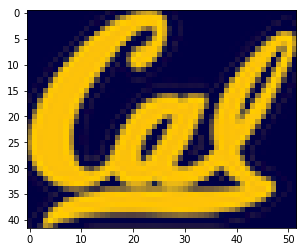

In [10]:
img = misc.imread("rec_calBlue.tiff")
plt.imshow(img)